## Import Libraries

All all libraries must be installed which have been imported in the next code block.

In [2]:
## Importing libraries
import pandas as pd
import numpy as np
import os
import pickle
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In this loading phase of our project we are labeling data as well as images into a list

In [22]:
DIRECTORY = 'Data/'
CATEGORIES = ['Cloth mask','Mask worn incorrectly','N-95_Mask','No Face Mask','Surgical Mask']

data = []
labels = []
 
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    average1 = 0  
    average2 = 0
    number =  0
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        
        try:
            image = Image.open(img_path)
            average1 +=image.size[0]
            average2 +=image.size[1]
            number +=1
            data.append(image)
            labels.append(category)
        except:
            pass  
    average1 = average1 /number 
    average2 = average2 /number 
    print("Average for class ",category," is ", average1, "X", average2)

Average for class  Cloth mask  is  461.1581508515815 X 422.3211678832117
Average for class  Mask worn incorrectly  is  395.42 X 424.575
Average for class  N-95_Mask  is  327.709219858156 X 289.82978723404256
Average for class  No Face Mask  is  239.9175704989154 X 227.0108459869848
Average for class  Surgical Mask  is  435.66511627906976 X 369.16046511627906


## Split dataset into train, validation, and test datasets

This is spliting phase. For this task, sklearn has been used. 

In [23]:
total_images = len(data)
train_dataset_size = 1590
test_dataset_size = total_images - train_dataset_size
test_dataset_percentage = test_dataset_size/total_images
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=test_dataset_percentage, random_state=42)
data_train, data_val, labels_train, labels_val = train_test_split(data_train, labels_train, test_size=0.1, random_state=42)

In [24]:
print('Before Preprocessing ...')
print('Number of Train Dataset Images:', len(data_train))
print('Number of Validation Dataset Images:', len(data_val))
print('Number of Test Dataset Images:', len(data_test))

Before Preprocessing ...
Number of Train Dataset Images: 1431
Number of Validation Dataset Images: 159
Number of Test Dataset Images: 535


## Preprocessing

All images are in different shape and size so before feeding to CNN network. All of them must be converted in same size (hight, width, and depth). Also for better results from model, a few images have been fliped or rotated. 

In [26]:
# Imagenet standards
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Train uses data augmentation
train_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))  
])
    
# Validation does not use augmentation
test_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])

For each class, a label in integer format is assigned:  <br>
0: Cloth Mask, 1: Mask Worn Incorrectly, 2: N-95 Mask, 3: NO Face Mask 4: Surgical Mask

In [27]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
labels_train = lb_make.fit_transform(labels_train)
labels_val = lb_make.transform(labels_val)
labels_test = lb_make.transform(labels_test)

In [28]:
train_images = []
train_labels = []


for i in range(len(data_train)):
    try:
        train_images.append(train_transforms(data_train[i]))
        train_labels.append(labels_train[i])
    except:
        pass
    
val_images = []
val_labels = []
for i in range(len(data_test)):
    try:
        val_images.append(test_transforms(data_val[i]))
        val_labels.append(labels_val[i])
    except:
        pass

test_images = []
test_labels = []
for i in range(len(data_test)):
    try:
        test_images.append(test_transforms(data_test[i]))
        test_labels.append(labels_test[i])
    except:
        pass

Here, all numpy arrays are converted into tensor.

In [33]:
train_images_numpy = [t.numpy() for t in train_images]
val_images_numpy = [t.numpy() for t in val_images]
test_images_numpy = [t.numpy() for t in test_images]

train_images_tensor = torch.tensor(train_images_numpy)
val_images_tensor = torch.tensor(val_images_numpy)
test_images_tensor = torch.tensor(test_images_numpy)

train_labels_tensor = torch.tensor(train_labels)
val_labels_tensor = torch.tensor(val_labels, dtype = torch.long)
test_labels_tensor = torch.tensor(test_labels)

In [34]:
print('After Preprocessing ...')
print('Number of Train Dataset Images:', len(train_images_tensor))
print('Number of Validation Dataset Images:', len(val_images_tensor))
print('Number of Test Dataset Images:', len(test_images_tensor))
print('Total Number of Training Images:', len(train_images_tensor)+len(val_images_tensor))
print('Total Number of Test Images:', len(test_images_tensor))
print('Total Number of Images:', len(train_images_tensor)+len(val_images_tensor)+ len(test_images_tensor))

After Preprocessing ...
Number of Train Dataset Images: 1368
Number of Validation Dataset Images: 147
Number of Test Dataset Images: 506
Total Number of Training Images: 1515
Total Number of Test Images: 506
Total Number of Images: 2021


## Importing data into Pytroch DataLoader

In [35]:
class CreateDataset:
    def __init__(self, images, labels):
        
        self.images = images
        self.labels = labels
    
    def __getitem__(self, index):
        
        image = self.images[index]
        label = self.labels[index]
        
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [36]:
train_dataset = CreateDataset(images=train_images_tensor, labels=train_labels_tensor)
val_dataset = CreateDataset(images=val_images_tensor, labels=val_labels_tensor)
test_dataset = CreateDataset(images=test_images_tensor, labels=test_labels_tensor)

In [38]:
batch_size_train = 64
batch_size_val = 64
batch_size_test = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size_train,
                                           shuffle=True,
                                           drop_last=False)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=batch_size_val,
                                           shuffle=True,
                                           drop_last=False)                                           

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                         batch_size=batch_size_test,
                                         shuffle=False,
                                         drop_last=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


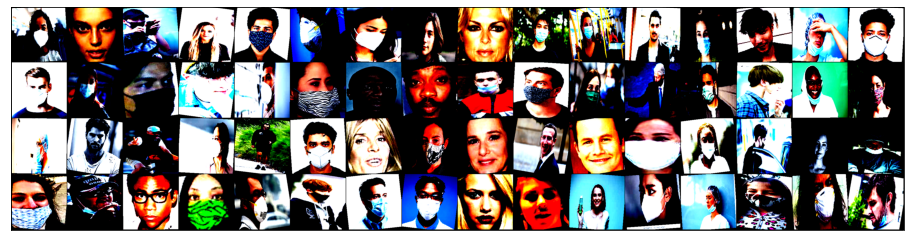

In [39]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)
plt.savefig('Figures/images_after_pre_process.jpg')

## Models

In [40]:
## Model 1

class net_ver1(nn.Module):
    def __init__(self):
        super(net_ver1, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(28 * 28 * 64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(32, 5)
        )

        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return F.log_softmax(x, dim = 1)


In [42]:
## Model 2

class net_ver2(nn.Module):
    def __init__(self):
        super(net_ver2, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(56 * 56 * 32, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(32, 5)
        )

        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)

        return F.log_softmax(x, dim = 1)

In [43]:
## Model 3

class net_ver3(nn.Module):
    def __init__(self):
        super(net_ver3, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(16)
        )
        
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(32)
        )
        
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(224 * 224 * 32, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(32, 5)
        )

        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return F.log_softmax(x, dim = 1)

### Train and Validation Function

In [44]:
def train_val(model_info, train_loader, val_loader, num_epochs):

    model = model_info['model']
    optimizer =  model_info['optimizer']
    criterion = model_info['criterion']
    path = model_info['path']

    loss_train = []
    loss_val = []
    loss_train_avg = []
    loss_val_avg = []

    acc_train = []
    acc_val = []
    acc_train_avg = []
    acc_val_avg = []

    info_loss_acc = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

    # Training
    for epoch in range(num_epochs):
        
        model.train()
        loss_train = []
        acc_train = []
        
        for i, (images,labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_train.append(loss.item())
            
            # Backprop and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Train accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_train.append(correct / total)

        loss_train_avg.append(sum(loss_train)/len(train_loader))
        acc_train_avg.append(sum(acc_train)/len(train_loader))
        
        # Validaiton
        loss_val = []
        acc_val = []
        model.eval()

        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images,labels) in enumerate(val_loader):
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss_val.append(loss.item())
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                acc_val.append(correct / total)

            loss_val_avg.append(sum(loss_val)/len(val_loader))
            acc_val_avg.append(sum(acc_val)/len(val_loader))


        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'
        .format(epoch + 1, num_epochs, loss_train_avg[epoch], acc_train_avg[epoch] * 100,
        loss_val_avg[epoch], acc_val_avg[epoch] * 100))

        
    torch.save(model,path+'model_'+str(epoch+1)+'.pth')

    info_loss_acc['train_loss'] = loss_train_avg
    info_loss_acc['train_acc '] = acc_train_avg
    info_loss_acc['val_loss'] = loss_val_avg
    info_loss_acc['val_acc'] = acc_val_avg

    with open(path+'info_loss_acc.pkl', 'wb') as f:
        pickle.dump(info_loss_acc, f)

    return model, info_loss_acc

### Test function

In [45]:
def test(model, test_loader, num_test_images):

    # Test:
    output_true = []
    output_pred = []
    batch_size_test = 64

    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images,labels) in enumerate(test_loader):
            output_true.append(labels)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            output_pred.append(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = (correct / total) * 100

        print('Testing Accuracy of the model on the test images: {} %'
            .format(test_acc))

    y_pred = np.zeros(num_test_images)
    y_true = np.zeros(num_test_images)
    for i in range(len(output_pred)):
        for j in range(output_pred[i].shape[0]):
            y_pred[i*(batch_size_test)+j] = output_pred[i][j]
            y_true[i*(batch_size_test)+j] = output_true[i][j]

    y_pred = y_pred.reshape(-1)
    y_true = y_true.reshape(-1)

    return model, y_pred, y_true

## Training Models

### Model 1

In [46]:
num_epochs = 100
learning_rate = 0.001
model_1 = net_ver1()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=learning_rate)
model_info_1 = {'model':model_1, 'optimizer':optimizer, 'criterion':criterion, 'path':'Models/ver1/'}

In [66]:
model_1, info_loss_acc_1 = train_val(model_info_1, train_loader, val_loader, num_epochs)

Epoch [1/100], Train Loss: 1.6179, Train Accuracy: 20.71, Validation Loss: 1.6181, Validation Accuracy: 20.25%
Epoch [2/100], Train Loss: 1.5946, Train Accuracy: 24.55, Validation Loss: 1.5974, Validation Accuracy: 21.03%
Epoch [3/100], Train Loss: 1.5727, Train Accuracy: 30.05, Validation Loss: 1.5531, Validation Accuracy: 34.85%
Epoch [4/100], Train Loss: 1.5397, Train Accuracy: 35.70, Validation Loss: 1.5390, Validation Accuracy: 39.99%
Epoch [5/100], Train Loss: 1.5181, Train Accuracy: 35.14, Validation Loss: 1.4897, Validation Accuracy: 43.00%
Epoch [6/100], Train Loss: 1.4731, Train Accuracy: 38.13, Validation Loss: 1.4730, Validation Accuracy: 44.23%
Epoch [7/100], Train Loss: 1.4310, Train Accuracy: 39.14, Validation Loss: 1.4218, Validation Accuracy: 45.20%
Epoch [8/100], Train Loss: 1.4027, Train Accuracy: 41.86, Validation Loss: 1.4163, Validation Accuracy: 47.99%
Epoch [9/100], Train Loss: 1.3911, Train Accuracy: 42.37, Validation Loss: 1.3631, Validation Accuracy: 42.78%
E

## Model 2

In [98]:
num_epochs = 100
learning_rate = 0.001
model_2 = net_ver2()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=learning_rate)
model_info_2 = {'model':model_2, 'optimizer':optimizer, 'criterion':criterion, 'path':'Models/ver2/'}

In [99]:
model_2, info_loss_acc_2 = train_val(model_info_2, train_loader, val_loader, num_epochs)

Epoch [1/100], Train Loss: 1.5953, Train Accuracy: 20.90, Validation Loss: 1.6080, Validation Accuracy: 17.95%
Epoch [2/100], Train Loss: 1.5773, Train Accuracy: 23.33, Validation Loss: 1.5765, Validation Accuracy: 27.18%
Epoch [3/100], Train Loss: 1.5475, Train Accuracy: 26.12, Validation Loss: 1.5365, Validation Accuracy: 27.40%
Epoch [4/100], Train Loss: 1.5322, Train Accuracy: 27.90, Validation Loss: 1.5347, Validation Accuracy: 24.57%
Epoch [5/100], Train Loss: 1.4965, Train Accuracy: 31.06, Validation Loss: 1.5163, Validation Accuracy: 22.27%
Epoch [6/100], Train Loss: 1.4767, Train Accuracy: 36.14, Validation Loss: 1.4945, Validation Accuracy: 30.34%
Epoch [7/100], Train Loss: 1.4423, Train Accuracy: 36.58, Validation Loss: 1.4750, Validation Accuracy: 32.95%
Epoch [8/100], Train Loss: 1.4183, Train Accuracy: 38.96, Validation Loss: 1.4532, Validation Accuracy: 40.10%
Epoch [9/100], Train Loss: 1.3947, Train Accuracy: 42.51, Validation Loss: 1.4450, Validation Accuracy: 38.46%
E

## Model 3

In [19]:
num_epochs = 100
learning_rate = 0.001
model_3 = net_ver3()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=learning_rate)
model_info_3 = {'model':model_3, 'optimizer':optimizer, 'criterion':criterion, 'path':'Models/ver3/'}

In [20]:
model_3, info_loss_acc_3 = train_val(model_info_3, train_loader, val_loader, num_epochs)

Epoch [1/100], Train Loss: 1.5439, Train Accuracy: 30.82, Validation Loss: 1.5135, Validation Accuracy: 42.93%
Epoch [2/100], Train Loss: 1.4000, Train Accuracy: 44.91, Validation Loss: 1.3575, Validation Accuracy: 45.82%
Epoch [3/100], Train Loss: 1.3234, Train Accuracy: 48.46, Validation Loss: 1.3395, Validation Accuracy: 48.26%
Epoch [4/100], Train Loss: 1.2425, Train Accuracy: 52.11, Validation Loss: 1.3090, Validation Accuracy: 50.63%
Epoch [5/100], Train Loss: 1.1802, Train Accuracy: 56.11, Validation Loss: 1.2782, Validation Accuracy: 50.01%
Epoch [6/100], Train Loss: 1.1311, Train Accuracy: 58.19, Validation Loss: 1.2532, Validation Accuracy: 56.16%
Epoch [7/100], Train Loss: 1.0722, Train Accuracy: 63.38, Validation Loss: 1.2430, Validation Accuracy: 54.79%
Epoch [8/100], Train Loss: 1.0181, Train Accuracy: 65.58, Validation Loss: 1.3148, Validation Accuracy: 53.04%
Epoch [9/100], Train Loss: 0.9723, Train Accuracy: 66.41, Validation Loss: 1.2598, Validation Accuracy: 53.62%
E

## Test Models

#### Model 1

In [40]:
load_model = True
path_model = 'Models/ver1/model_100.pth'
path_dict = 'Models/ver1/info_loss_acc.pkl'
if load_model == True:
    model_1 = torch.load(path_model)
    model_1.eval()
    with open(path_dict, 'rb') as f:
        info_loss_acc_1 = pickle.load(f)
num_test_images = len(test_images_tensor)
model_1, y_pred_1, y_true_1 = test(model_1, test_loader, num_test_images)

Testing Accuracy of the model on the test images: 72.33201581027669 %


In [41]:
loss_train_avg = info_loss_acc_1['train_loss']
acc_train_avg = info_loss_acc_1['train_acc ']
loss_val_avg = info_loss_acc_1['val_loss'] 
acc_val_avg = info_loss_acc_1['val_acc'] 

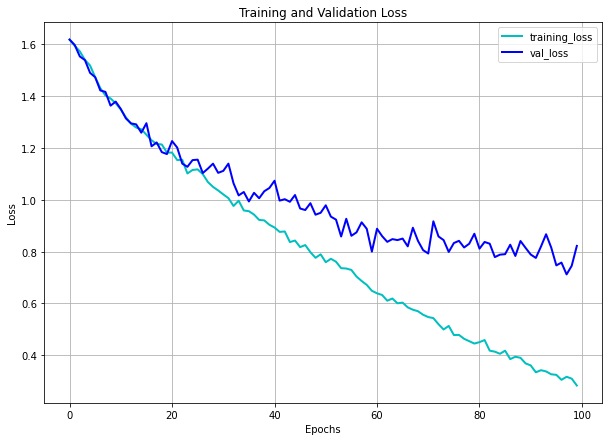

In [42]:
## Loss
plt.figure(figsize=(10,7))
plt.plot(loss_train_avg, 'c', markersize=12, markeredgewidth=3
         , linewidth=2,label='training_loss')
plt.plot(loss_val_avg, 'b', markersize=12, markeredgewidth=3
         , linewidth=2,label='val_loss')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.savefig('Figures/ver1/loss.jpg')

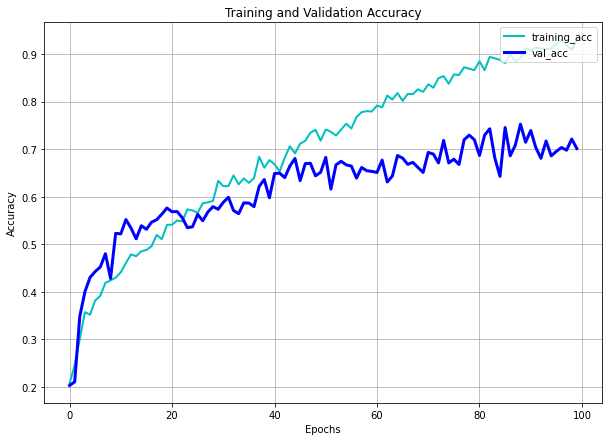

In [43]:
## Accuracy
plt.figure(figsize=(10,7))
plt.plot(acc_train_avg, 'c', markersize=12, markeredgewidth=3
         , linewidth=2,label='training_acc')
plt.plot(acc_val_avg, 'b', markersize=8, markeredgewidth=3
         , linewidth=3,label='val_acc')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.savefig('Figures/ver1/accuracy.jpg')

In [68]:
print('Classification Report: \n', classification_report(y_true_1, y_pred_1))
conf_mat = confusion_matrix(y_true_1, y_pred_1)
print('confusiton matrix: \n', conf_mat)

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.66      0.66      0.66        83
         1.0       0.66      0.52      0.58       109
         2.0       0.68      0.80      0.73        89
         3.0       0.82      0.88      0.85       113
         4.0       0.76      0.75      0.75       112

    accuracy                           0.72       506
   macro avg       0.72      0.72      0.72       506
weighted avg       0.72      0.72      0.72       506

confusiton matrix: 
 [[55 12  7  4  5]
 [14 57 12 11 15]
 [ 5  4 71  4  5]
 [ 3  9  0 99  2]
 [ 6  5 15  2 84]]


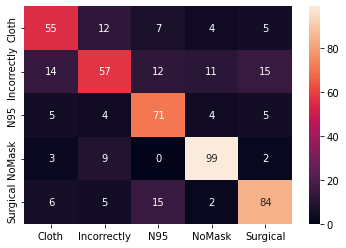

In [69]:
categories = ['Cloth','Incorrectly', 'N95', 'NoMask', 'Surgical']
df_cm = pd.DataFrame(conf_mat, categories, categories)
sns_plot = sns.heatmap(df_cm, annot=True)
sns_plot.figure.savefig("Figures/ver1/conf_mat.png")

#### Model 2

In [46]:
load_model = True
path_model = 'Models/ver2/model_100.pth'
path_dict = 'Models/ver2/info_loss_acc.pkl'
if load_model == True:
    model_2 = torch.load(path_model)
    model_2.eval()
    with open(path_dict, 'rb') as f:
        info_loss_acc_2 = pickle.load(f)
num_test_images = len(test_images_tensor)
model_2, y_pred_2, y_true_2 = test(model_2, test_loader, num_test_images)

Testing Accuracy of the model on the test images: 70.7509881422925 %


In [47]:
loss_train_avg = info_loss_acc_2['train_loss']
acc_train_avg = info_loss_acc_2['train_acc ']
loss_val_avg = info_loss_acc_2['val_loss'] 
acc_val_avg = info_loss_acc_2['val_acc'] 

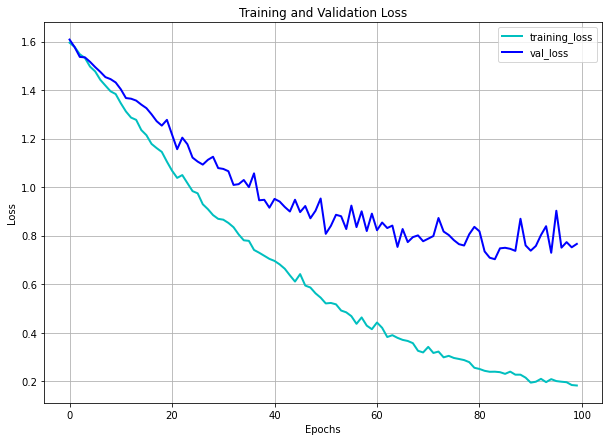

In [48]:
## Loss
plt.figure(figsize=(10,7))
plt.plot(loss_train_avg, 'c', markersize=12, markeredgewidth=3
         , linewidth=2,label='training_loss')
plt.plot(loss_val_avg, 'b', markersize=12, markeredgewidth=3
         , linewidth=2,label='val_loss')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.savefig('Figures/ver2/loss.jpg')

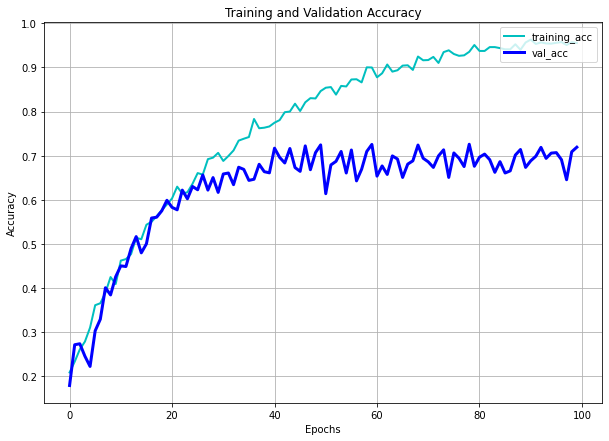

In [49]:
## Accuracy
plt.figure(figsize=(10,7))
plt.plot(acc_train_avg, 'c', markersize=12, markeredgewidth=3
         , linewidth=2,label='training_acc')
plt.plot(acc_val_avg, 'b', markersize=8, markeredgewidth=3
         , linewidth=3,label='val_acc')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.savefig('Figures/ver2/accuracy.jpg')

In [66]:
print('Classification Report: \n', classification_report(y_true_2, y_pred_2))
conf_mat = confusion_matrix(y_true_2, y_pred_2)
print('confusiton matrix: \n', conf_mat)

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.64      0.54      0.59        83
         1.0       0.57      0.63      0.60       109
         2.0       0.69      0.74      0.72        89
         3.0       0.84      0.84      0.84       113
         4.0       0.77      0.74      0.75       112

    accuracy                           0.71       506
   macro avg       0.70      0.70      0.70       506
weighted avg       0.71      0.71      0.71       506

confusiton matrix: 
 [[45 14  7 10  7]
 [16 69 10  6  8]
 [ 1 11 66  1 10]
 [ 3 12  3 95  0]
 [ 5 14  9  1 83]]


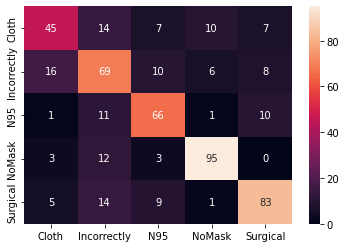

In [67]:
categories = ['Cloth','Incorrectly', 'N95', 'NoMask', 'Surgical']
df_cm = pd.DataFrame(conf_mat, categories, categories)
sns_plot = sns.heatmap(df_cm, annot=True)
sns_plot.figure.savefig("Figures/ver2/conf_mat.png")

#### Model 3

In [62]:
load_model = True
path_model = 'Models/ver3/model_100.pth'
path_dict = 'Models/ver3/info_loss_acc.pkl'
if load_model == True:
    model_3 = torch.load(path_model)
    model_3.eval()
    with open(path_dict, 'rb') as f:
        info_loss_acc_3 = pickle.load(f)
num_test_images = len(test_images_tensor)
model_3, y_pred_3, y_true_3 = test(model_3, test_loader, num_test_images)

Testing Accuracy of the model on the test images: 65.61264822134387 %


In [63]:
loss_train_avg = info_loss_acc_3['train_loss']
acc_train_avg = info_loss_acc_3['train_acc ']
loss_val_avg = info_loss_acc_3['val_loss'] 
acc_val_avg = info_loss_acc_3['val_acc'] 

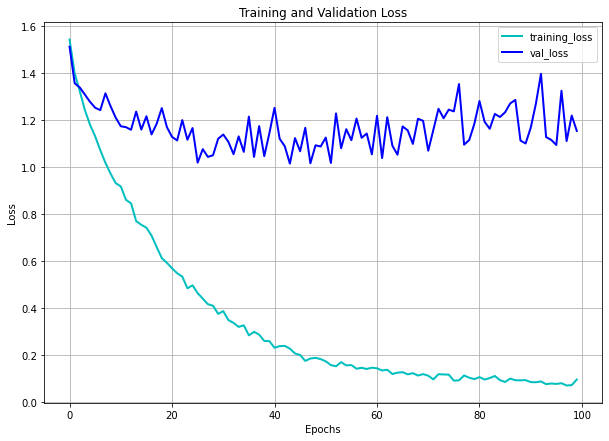

In [64]:
## Loss
plt.figure(figsize=(10,7))
plt.plot(loss_train_avg, 'c', markersize=12, markeredgewidth=3
         , linewidth=2,label='training_loss')
plt.plot(loss_val_avg, 'b', markersize=12, markeredgewidth=3
         , linewidth=2,label='val_loss')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.savefig('Figures/ver3/loss.jpg')

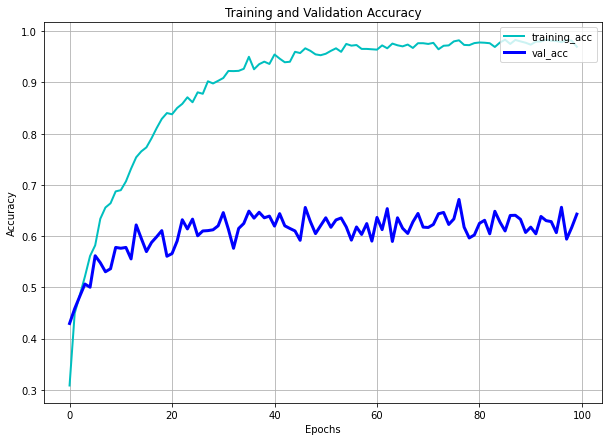

In [65]:
## Accuracy
plt.figure(figsize=(10,7))
plt.plot(acc_train_avg, 'c', markersize=12, markeredgewidth=3
         , linewidth=2,label='training_acc')
plt.plot(acc_val_avg, 'b', markersize=8, markeredgewidth=3
         , linewidth=3,label='val_acc')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.savefig('Figures/ver3/accuracy.jpg')

In [66]:
print('Classification Report: \n', classification_report(y_true_3, y_pred_3))
conf_mat = confusion_matrix(y_true_3, y_pred_3)
print('confusiton matrix: \n', conf_mat)

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.63      0.52      0.57        83
         1.0       0.60      0.50      0.55       109
         2.0       0.56      0.76      0.65        89
         3.0       0.78      0.84      0.81       113
         4.0       0.69      0.63      0.66       112

    accuracy                           0.66       506
   macro avg       0.65      0.65      0.65       506
weighted avg       0.66      0.66      0.65       506

confusiton matrix: 
 [[43 10  9 11 10]
 [12 55 18 11 13]
 [ 3  6 68  3  9]
 [ 4 11  3 95  0]
 [ 6 10 23  2 71]]


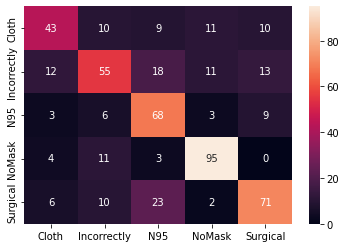

In [67]:
categories = ['Cloth','Incorrectly', 'N95', 'NoMask', 'Surgical']
df_cm = pd.DataFrame(conf_mat, categories, categories)
sns_plot = sns.heatmap(df_cm, annot=True)
sns_plot.figure.savefig("Figures/ver3/conf_mat.png")